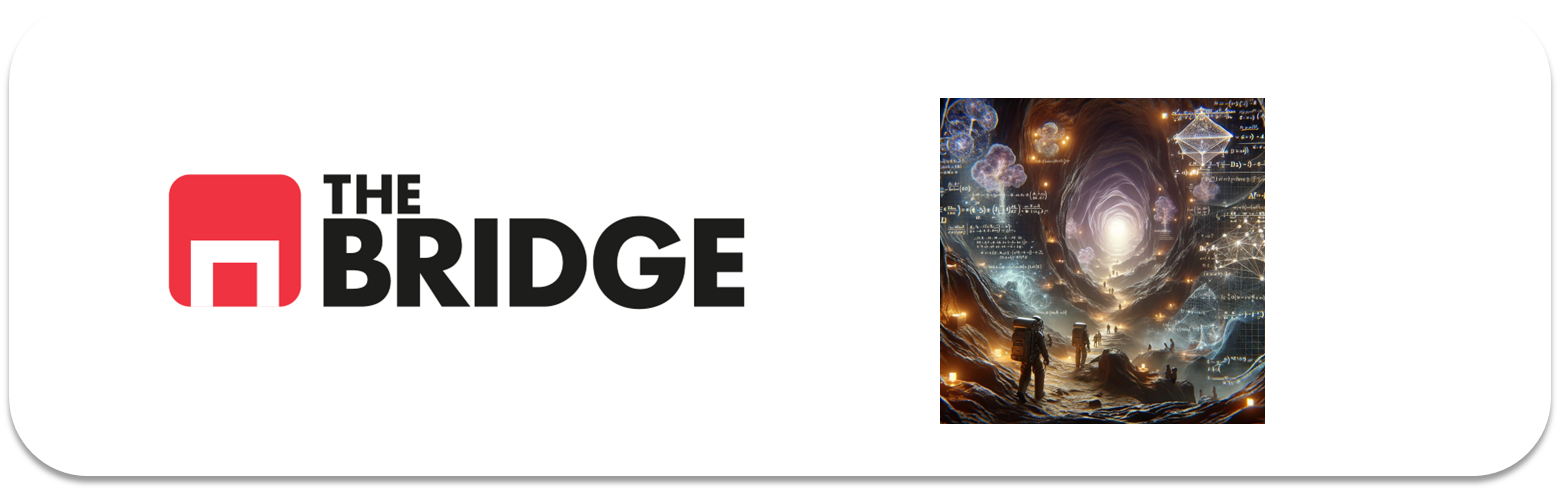

## PRACTICA OBLIGATORIA: **Introducción Deep Learning**

* La práctica obligatoria de esta unidad consiste en un único ejercicio de modelado del dataset del titanic empleando y comparando dos modelos diferentes. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [36]:
import bootcampviztools as bt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

### Descripción y objetivo

El objetivo de la práctica es crear un modelo DL y compararlo con un modelo Random Forest para el dataset de titanic los dos con el mismo objetivo, predecir la supervivencia de un pasajero.  Se pide:  
1. Desarrollar el proceso de ML hasta crear los dos modelos DL y Random Forest. El primero debe tener una topología MLP (es decir una red densa) con un máximo de 3 capas ocultas y debes emplear sklearn para crearlo. No es necesario hacer una análisis/seleccion exahustivo. Escoge una métrica acorde al tipo de target del problema. 

2. Ambos modelos deben tener sus hiperparámetros optimizados, mediante GridSearch. Para ello: utiliza el grid de parámetros que creas conveniente para Random Forest y para el modelo DL, utiliza un grid con los hiperparámetros siguientes:'hidden_layer_sizes','activation', 'solver','alpha' y 'learning_rate'. Para los rangos del grid del modelo de DL guíate por lo visto en el workout y por los posibles valores que se indican en la [documentación](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier). Prueba por lo menos una topología con una sola capa oculta y otra con más de una capa oculta.   
NOTA: Incluye los valores por defecto de los hiperparámetros escogidos en cada caso dentro del grid de hiperparámetros. 
  

3. Compara los modelos respecto a sus métricas medias de accuracy, precision, recall y tiempos de entrenamiento (para ello tendrás que realizar un entrenamiento a parte del mejor modelo obtenido en la optimización de hiperparámetros) y decide cuál te quedarías argumentándolo.    

4. Para el mejor modelo DL obtenido, muestra su clasification report, y la matriz de confusión comentando el resultado.



### 1. Carga de datos y vistazo general

In [37]:
df = pd.read_csv("./data/titanic.csv")

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     891 non-null    int64  
 1   pclass       891 non-null    int64  
 2   sex          891 non-null    object 
 3   age          714 non-null    float64
 4   sibsp        891 non-null    int64  
 5   parch        891 non-null    int64  
 6   fare         891 non-null    float64
 7   embarked     889 non-null    object 
 8   class        891 non-null    object 
 9   who          891 non-null    object 
 10  adult_male   891 non-null    bool   
 11  deck         203 non-null    object 
 12  embark_town  889 non-null    object 
 13  alive        891 non-null    object 
 14  alone        891 non-null    bool   
dtypes: bool(2), float64(2), int64(4), object(7)
memory usage: 92.4+ KB


Observamos que hay nulos en edad, en embarked y embark_town y en cubierta.

In [39]:
# Proporción de valores nulos por columna
proporcion_nulos = df.isnull().mean()

print(proporcion_nulos)

survived       0.000000
pclass         0.000000
sex            0.000000
age            0.198653
sibsp          0.000000
parch          0.000000
fare           0.000000
embarked       0.002245
class          0.000000
who            0.000000
adult_male     0.000000
deck           0.772166
embark_town    0.002245
alive          0.000000
alone          0.000000
dtype: float64


- Como la proporción de nulos de la columna deck es mayor al 50% la eliminamos.
- Para embarked y embark_town como su proporción de nulos es tan pequeña podemos imputar la moda.
- Para edad podemos imputar la media en función de la columna who.

In [40]:
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


### 2. Split de train y test

In [41]:
train_set,test_set = train_test_split(df,test_size=0.2,random_state=42)

In [42]:
target = 'survived'

### 3. MiniEDA

In [43]:
train_set[target].value_counts(normalize = True)

survived
0    0.623596
1    0.376404
Name: proportion, dtype: float64

Como ya sabíamos con anterioridad es un dataset que está ligeramente desequilibrado pero vamos a continuar con él de este modo para ver qué resultados da.

In [44]:
# La columna embark_town la eliminamos porque aporta la misma información que embarked, del mismo modo haremos con class
# Deck la eliminamos por tener gran cantidad de nulos que no se pueden tratar

train_set = train_set.drop(columns = ['deck', 'embark_town'])
test_set = test_set.drop(columns = ['deck', 'embark_town'])

In [45]:
# Imputamos los nulos de la columna embark por la moda
train_set.loc[train_set["embarked"].isna(), "embarked"] = train_set["embarked"].mode()[0]
test_set.loc[test_set["embarked"].isna(), "embarked"] = test_set["embarked"].mode()[0]


In [46]:
# imputamos los nulos de la columna age por la media en función de la columna who
es_hombre = train_set.who == "man"
es_mujer = train_set.who == "woman"
es_child = train_set.who == "child"

mean_man = train_set[es_hombre]["age"].mean()
mean_woman = train_set[es_mujer]["age"].mean()
mean_child = train_set[es_child]["age"].mean()
es_nulo = train_set.age.isna()
es_nulo_test = test_set.age.isna()

#Imputamos en train
train_set.loc[es_hombre & es_nulo, "age"] = mean_man
train_set.loc[es_mujer & es_nulo, "age"] = mean_woman
train_set.loc[es_child & es_nulo, "age"] = mean_child

#Imputamos en test
test_set.loc[(test_set.who == "man") & es_nulo_test, "age"] = mean_man
test_set.loc[(test_set.who == "woman") & es_nulo_test, "age"] = mean_woman
test_set.loc[(test_set.who == "child") & es_nulo_test, "age"] = mean_child

In [47]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 331 to 102
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   survived    712 non-null    int64  
 1   pclass      712 non-null    int64  
 2   sex         712 non-null    object 
 3   age         712 non-null    float64
 4   sibsp       712 non-null    int64  
 5   parch       712 non-null    int64  
 6   fare        712 non-null    float64
 7   embarked    712 non-null    object 
 8   class       712 non-null    object 
 9   who         712 non-null    object 
 10  adult_male  712 non-null    bool   
 11  alive       712 non-null    object 
 12  alone       712 non-null    bool   
dtypes: bool(2), float64(2), int64(4), object(5)
memory usage: 68.1+ KB


In [48]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 179 entries, 709 to 10
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   survived    179 non-null    int64  
 1   pclass      179 non-null    int64  
 2   sex         179 non-null    object 
 3   age         179 non-null    float64
 4   sibsp       179 non-null    int64  
 5   parch       179 non-null    int64  
 6   fare        179 non-null    float64
 7   embarked    179 non-null    object 
 8   class       179 non-null    object 
 9   who         179 non-null    object 
 10  adult_male  179 non-null    bool   
 11  alive       179 non-null    object 
 12  alone       179 non-null    bool   
dtypes: bool(2), float64(2), int64(4), object(5)
memory usage: 17.1+ KB


In [49]:
features_cat = ['pclass','sex', 'embarked', 'who', 'adult_male', 'alone']
features_num = ["age","sibsp","parch","fare"]

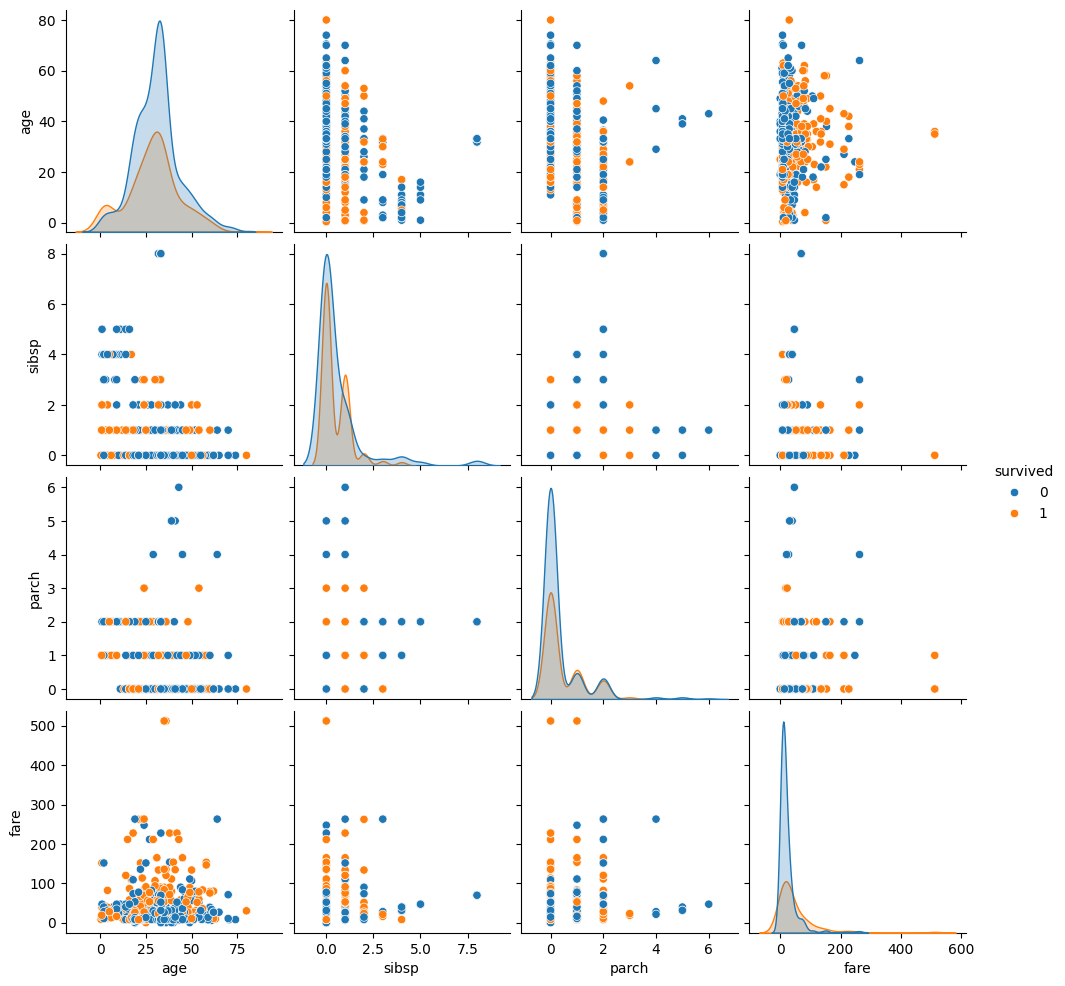

In [50]:
# Análisis visual de numéricas:

sns.pairplot(train_set[features_num + [target]], hue = target)

In [51]:
#parch no discrimina asi que no la usaremos
features_num = ["fare","age","sibsp"]

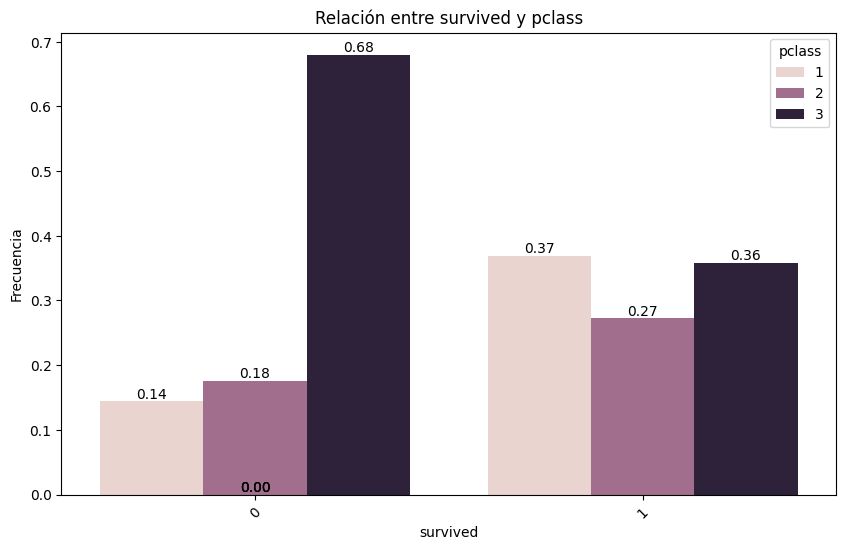

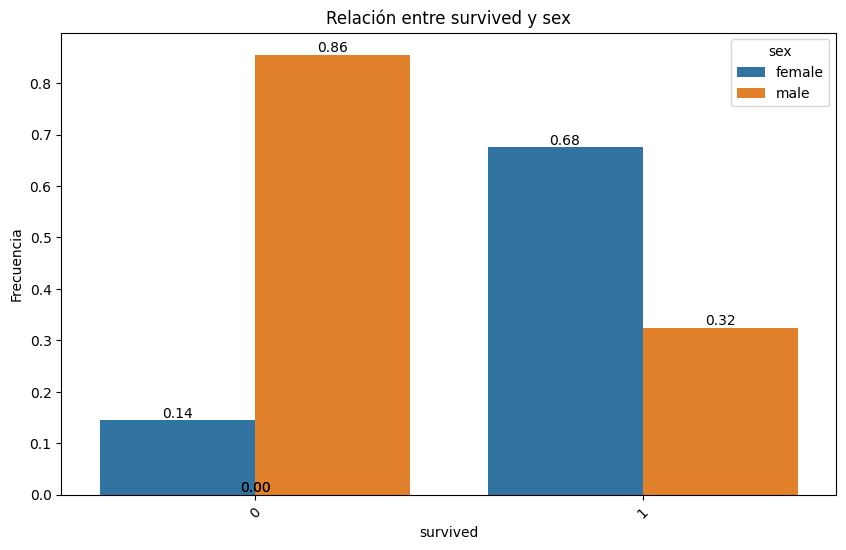

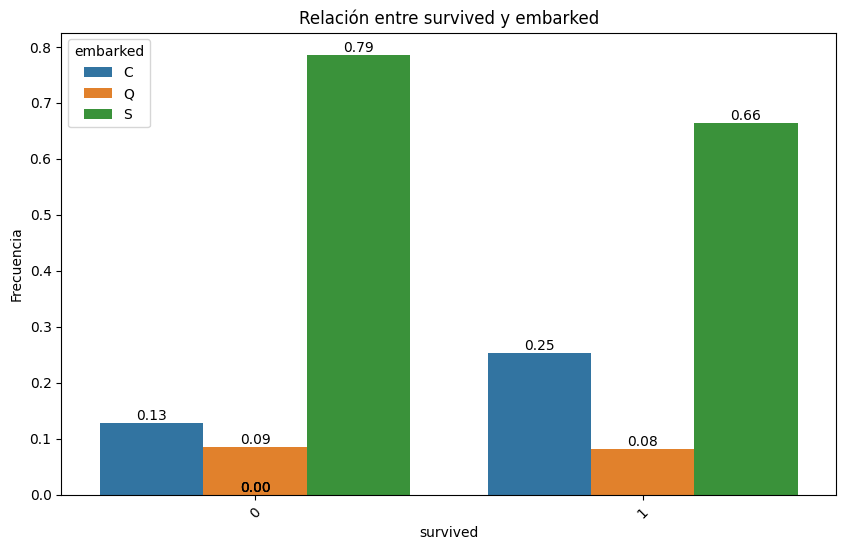

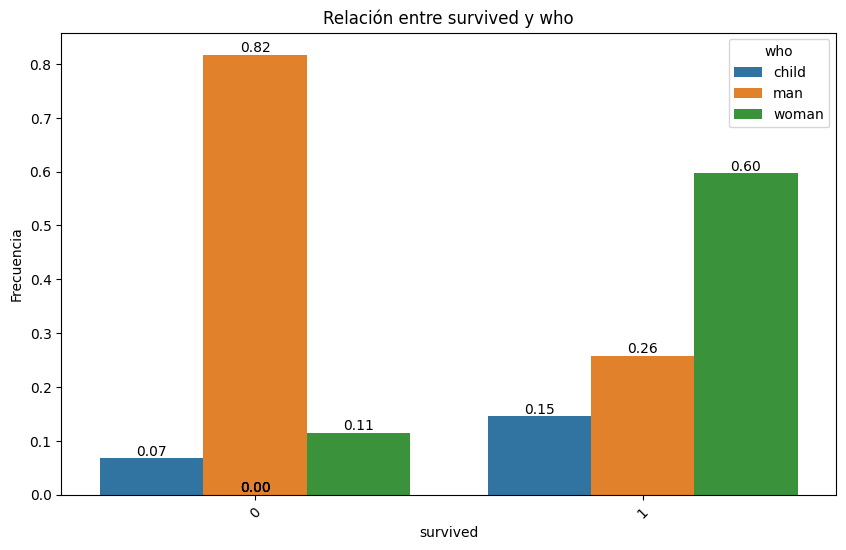

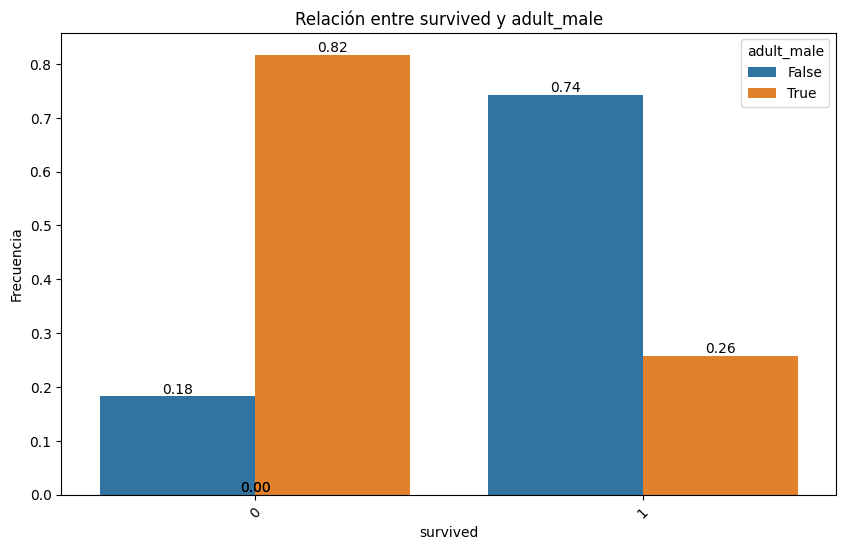

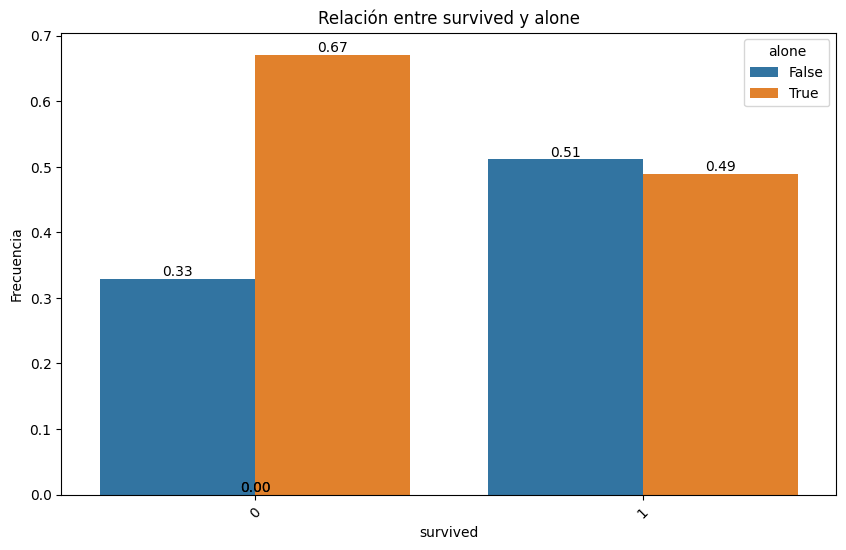

In [52]:
# Análisis visual de categóricas
for feat in features_cat:
    bt.plot_categorical_relationship_fin(train_set, target, feat, show_values= True, relative_freq= True)

In [53]:
# Descartamos adult_male y sex porque son redundantes
features_cat = ['pclass', 'embarked', 'who', 'alone']

### 4. Procesamiento de features

In [54]:
from sklearn.preprocessing import OrdinalEncoder

In [55]:
# Categóricas:
categories = [["S","C","Q"], ["child","woman","man"]] 

encoder = OrdinalEncoder(categories= categories)

train_set[["embarked","who"]] = encoder.fit_transform(train_set[["embarked","who"]])
test_set[["embarked","who"]] = encoder.transform(test_set[["embarked","who"]])

In [56]:
train_set[["embarked","who"]]

,embarked,who
331,0.0,2.0
733,0.0,2.0
382,0.0,2.0
704,0.0,2.0
813,0.0,0.0
...,...,...
106,0.0,1.0
270,0.0,2.0
860,0.0,2.0
435,0.0,0.0


array([[<Axes: title={'center': 'fare'}>,
        <Axes: title={'center': 'age'}>],
       [<Axes: title={'center': 'sibsp'}>, <Axes: >]], dtype=object)

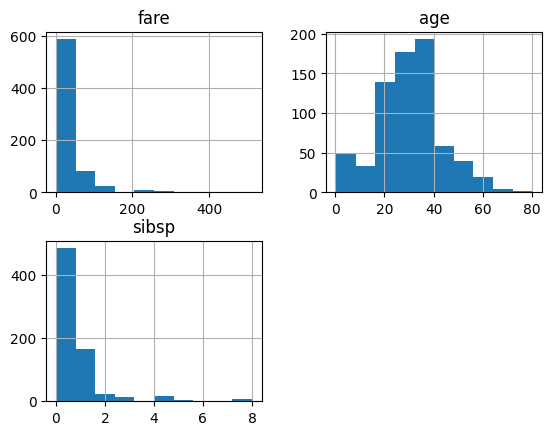

In [57]:
# Comprobamos distribución numéricas
train_set[features_num].hist()

In [58]:
# Como Sibsp tiene 0 no podemos aplicar logaritmo, así que por ejemplo podemos usar raíz cuadrada.
train_set["fare"] = np.sqrt(train_set["fare"])
test_set["fare"] = np.sqrt(test_set["fare"])
train_set["sibsp"] = np.sqrt(train_set["sibsp"])
test_set["sibsp"] = np.sqrt(test_set["sibsp"])

array([[<Axes: title={'center': 'fare'}>,
        <Axes: title={'center': 'age'}>],
       [<Axes: title={'center': 'sibsp'}>, <Axes: >]], dtype=object)

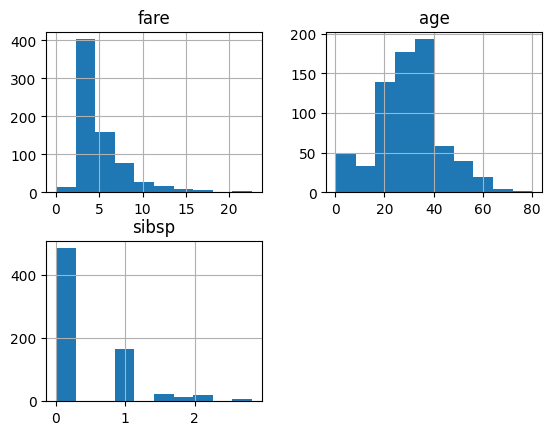

In [59]:
train_set[features_num].hist()

In [60]:
# Escalamos
scaler = StandardScaler()

train_set[features_num] = scaler.fit_transform(train_set[features_num])
test_set[features_num] = scaler.transform(test_set[features_num])

In [61]:
train_set[features_num].describe()

,fare,age,sibsp
count,7.120000e+02,7.120000e+02,7.120000e+02
mean,2.164311e-16,-7.110417e-17,3.742325e-18
std,1.000703e+00,1.000703e+00,1.000703e+00
min,-1.612205e+00,-2.277474e+00,-6.290657e-01
25%,-6.766149e-01,-6.244175e-01,-6.290657e-01
50%,-3.486825e-01,1.307475e-01,-6.290657e-01
75%,2.232167e-01,3.713996e-01,9.590846e-01
max,5.910265e+00,3.818459e+00,3.862902e+00


### 5. Modelos


In [62]:
X_train = train_set[features_cat + features_num]
y_train = train_set[target]

X_test = test_set[features_cat + features_num]
y_test = test_set[target]

In [63]:
#RandomForest
from sklearn.ensemble import RandomForestClassifier


param_grid = {
    'n_estimators': [50, 100, 200],  # Número de árboles
    'max_depth': [None, 10, 20, 30],  # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],  # Mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],  # Mínimo de muestras para estar en una hoja
}


grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5,  
                           n_jobs=-1, 
                           verbose=2,  
                           scoring='accuracy')  # Métrica de evaluación (precisión)


# Entrenamos
grid_search.fit(X_train, y_train)

# Mejores parámetros
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Mejores parámetros encontrados:
{'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}


In [64]:
# Predicciones con el mejor modelo
best_model = grid_search.best_estimator_  
y_pred = best_model.predict(X_test)

In [65]:
# Obtenemos las métricas
print(classification_report(y_test, y_pred) )

              precision    recall  f1-score   support

           0       0.81      0.90      0.86       105
           1       0.84      0.70      0.76        74

    accuracy                           0.82       179
   macro avg       0.83      0.80      0.81       179
weighted avg       0.82      0.82      0.82       179



In [69]:
import time

In [70]:
# Tiempos del mejor modelo de RandomForest:
start_time = time.time()
best_model.fit(X_train, y_train)  
end_time = time.time()
tiempo = end_time - start_time

print(f"El tiempo del mejor modelo de RandomForest es: {tiempo}")

El tiempo del mejor modelo de RandomForest es: 0.30904626846313477


In [71]:
# MLP
from sklearn.neural_network import MLPClassifier

param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 30), (100, 50)],  # topologías con una cara oculta o dos caras ocultas
    'activation': ['relu', 'tanh'],  # Funciones de activación
    'solver': ['adam', 'sgd'],  # Algoritmos de optimización
    'alpha': [0.0001, 0.001, 0.01],  # Regularización L2
    'learning_rate': ['constant', 'adaptive'],  # Tasa de aprendizaje
    'max_iter': [200, 300, 500]  
}

grid_search = GridSearchCV(estimator=MLPClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5,  
                           n_jobs=-1,  
                           verbose=2,  
                           scoring='accuracy')  

# Entrenamos
grid_search.fit(X_train, y_train)

# Mejores parámetros 
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)


Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Mejores parámetros encontrados:
{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 500, 'solver': 'adam'}


c:\Users\maria\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


NOTA: debería aumentar el número de iteraciones pero no sé si mi ordenador podrá con ello así que de momento lo dejo así.

In [72]:
# Predicciones con el mejor modelo
best_model = grid_search.best_estimator_  
y_pred = best_model.predict(X_test)

In [73]:
# Tiempos del mejor modelo de MLP:
start_time = time.time()
best_model.fit(X_train, y_train)  
end_time = time.time()
timpo = end_time - start_time

print(f"El tiempo del mejor modelo de MLP es: {tiempo}")

El tiempo del mejor modelo de MLP es: 0.30904626846313477


c:\Users\maria\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [74]:
# Obtenemos las métricas
print(classification_report(y_test, y_pred) )

              precision    recall  f1-score   support

           0       0.81      0.87      0.83       105
           1       0.79      0.70      0.74        74

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



Tras anaizar las métricas y los tiempos de entrenamiento de ambos modelos optimizados observamos que randomForest es ligeramente mejor.

In [76]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[91, 14],
       [22, 52]], dtype=int64)

In [79]:
import matplotlib.pyplot as plt

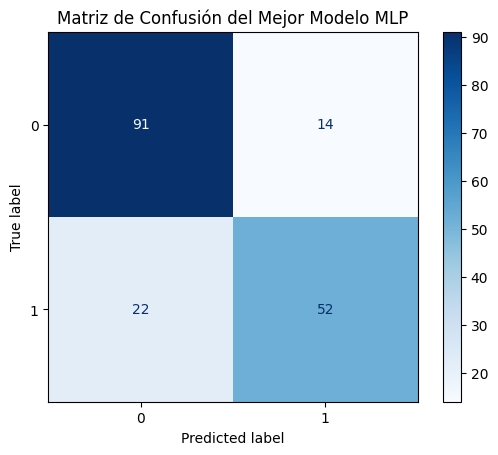

In [80]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión del Mejor Modelo MLP")
plt.show()

La matriz de confusión nos indica que:
- Hay 91 verdaderos positivos
- Hay 52 verdaderos negativos
- Hya 22 falsos positivos
- Hay 14 falsos negativos
 
 Por lo tanto, esto quiere decir que el modelo clasifica mejor la clase 0 que la 1.